In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import random
random.seed(42)
import re

Using TensorFlow backend.


In [2]:
model_dir = "sample_code_submission"
result_dir = 'sample_result_submission/' 
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'

In [3]:
from sys import path; path.append(model_dir); path.append(problem_dir); path.append(score_dir);

In [4]:
data_dir = 'input_data'
data_name = 'Areal'

**Read DATA**

In [5]:
from ingestion_program.data_io import read_as_df
data = read_as_df(data_dir  + '/' + data_name)

Reading input_data/Areal_train from AutoML format
Number of examples = 5200
Number of features = 49152
        Class
0       beach
1   chaparral
2       cloud
3      desert
4      forest
5      island
6        lake
7      meadow
8    mountain
9       river
10        sea
11   snowberg
12    wetland
Number of classes = 13


In [6]:
data.head()

,pixel_1_1_R,pixel_1_1_G,pixel_1_1_B,pixel_1_2_R,pixel_1_2_G,pixel_1_2_B,pixel_1_3_R,pixel_1_3_G,pixel_1_3_B,pixel_1_4_R,...,pixel_128_126_R,pixel_128_126_G,pixel_128_126_B,pixel_128_127_R,pixel_128_127_G,pixel_128_127_B,pixel_128_128_R,pixel_128_128_G,pixel_128_128_B,target
0,109,134,112,64,89,67,90,114,90,109,...,92,115,89,100,120,95,107,127,102,island
1,68,73,66,63,68,61,66,69,62,72,...,83,79,67,112,105,95,115,108,100,beach
2,119,142,122,110,134,112,104,129,107,104,...,131,132,136,130,131,136,134,135,140,beach
3,203,187,171,196,180,164,195,180,161,192,...,132,114,100,105,87,73,57,39,25,chaparral
4,229,222,203,227,220,201,225,218,199,233,...,83,105,102,59,81,78,82,104,101,beach


**Transform DATA**

In [5]:
from data_manager import DataManager
D = DataManager(data_name, data_dir, replace_missing=False, verbose=True)
print(D)

Info file found : C:\Users\TCO\Desktop\CHALL AREAL\input_data\Areal_public.info
========= Reading input_data\Areal_feat.type
[+] Success in  0.01 sec
========= Reading input_data\Areal_train.data
[+] Success in 73.55 sec
========= Reading input_data\Areal_train.solution
[+] Success in  0.02 sec
========= Reading input_data\Areal_valid.data
[+] Success in 24.92 sec
========= Reading input_data\Areal_valid.solution
[+] Success in  0.02 sec
========= Reading input_data\Areal_test.data
[+] Success in 25.07 sec
========= Reading input_data\Areal_test.solution
[+] Success in  0.01 sec
DataManager : Areal
info:
	name = areal
	metric = accuracy
	valid_num = 1950
	test_num = 1950
	has_categorical = 0
	is_sparse = 0
	has_missing = 0
	feat_num = 49152
	train_num = 5200
	feat_type = Numerical
	format = dense
	target_type = Categorical
	time_budget = 12000
	usage = Sample dataset Areal data
	target_num = 13
	task = multiclass.classification
	label_num = 13
data:
	X_train = array(5200, 49152)
	Y_tra

In [6]:
X_train = D.data['X_train']
Y_train = D.data['Y_train']

In [7]:
X_valid = D.data['X_valid']
Y_valid = D.data['Y_valid']

In [8]:
X_test = D.data['X_test']
Y_test = D.data['Y_test']

In [9]:
X_train = X_train.reshape(5200, 128, 128, 3)
X_valid = X_valid.reshape(1950, 128, 128, 3)
X_test = X_test.reshape(1950, 128, 128, 3)

In [10]:
from keras.utils import to_categorical

num_classes=13

Y_train = to_categorical(Y_train, num_classes)
Y_valid = to_categorical(Y_valid, num_classes)
Y_test = to_categorical(Y_test, num_classes)

**Create Model**

In [45]:
from keras import models
from keras import layers
from keras import optimizers
import keras.backend as K
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(128,128,3))
conv_base.trainable = False

# Design model
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(13,activation='softmax'))

rms=optimizers.RMSprop(lr=1e-4, decay=1e-5)

model.compile(loss='categorical_crossentropy',optimizer=rms,metrics=['accuracy'])

In [46]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 13)                3341      
Total params: 16,815,437
Trainable params: 2,100,749
Non-trainable params: 14,714,688
_________________________________________________________________


In [47]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

**Class to get Test Accuracy**

In [49]:
history_test_acc=[]
from keras.callbacks import Callback
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, log={}):
        x, y = self.test_data
        test_generator=test_datagen.flow(x, y, batch_size=batch_size)
        loss, acc = self.model.evaluate_generator(test_generator, steps=len(X_test)/batch_size)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))
        history_test_acc.append(acc)

**Fit**

In [48]:
datagen.fit(X_train)

In [50]:
epochs=15
batch_size=32

train_generator=datagen.flow(X_train, Y_train, batch_size=batch_size)
validation_generator=test_datagen.flow(X_valid, Y_valid, batch_size=batch_size)
#callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')]
#callbacks=callbacks
history = model.fit_generator(generator=train_generator, callbacks=[TestCallback((X_test, Y_test))], steps_per_epoch=len(X_train)/batch_size, epochs = epochs, validation_data=validation_generator, validation_steps=len(X_valid)/batch_size)

Epoch 1/15
163/162 [==============================] - 16s 98ms/step - loss: 1.5038 - acc: 0.5550 - val_loss: 1.0378 - val_acc: 0.7021

Testing loss: 1.0110599951866346, acc: 0.7179487177041861

Epoch 2/15
163/162 [==============================] - 15s 91ms/step - loss: 0.9805 - acc: 0.7082 - val_loss: 0.8559 - val_acc: 0.7174

Testing loss: 0.8364064385952094, acc: 0.7364102565936553

Epoch 3/15
163/162 [==============================] - 15s 92ms/step - loss: 0.8248 - acc: 0.7456 - val_loss: 0.7115 - val_acc: 0.7810

Testing loss: 0.6967126096823276, acc: 0.7958974361419677

Epoch 4/15
163/162 [==============================] - 15s 91ms/step - loss: 0.7394 - acc: 0.7743 - val_loss: 0.6613 - val_acc: 0.7985

Testing loss: 0.65723124620242, acc: 0.8087179484734168

Epoch 5/15
163/162 [==============================] - 15s 92ms/step - loss: 0.6774 - acc: 0.7874 - val_loss: 0.6447 - val_acc: 0.8010

Testing loss: 0.642663720143147, acc: 0.8087179489013476

Epoch 6/15
163/162 [=============

**Save Data**

In [53]:
mylist = history_test_acc

In [55]:
import pickle

with open('test_acc_vgg16.pkl', 'wb') as f:
    pickle.dump(mylist, f)

**Display Results**

In [56]:
training_loss_value, training_acc_value = model.evaluate_generator(train_generator, steps=len(X_train)/batch_size)
valid_loss_value, valid_acc_value = model.evaluate_generator(validation_generator, steps=len(X_valid)/batch_size)

In [57]:
print('training loss : {:.4f}'.format(training_loss_value))
print('validation_loss : {:.4f}'.format(valid_loss_value))
print(' ')
print('training accuracy : {:.2f} %'.format(100*training_acc_value))
print('validation accuracy : {:.2f} %'.format(100*valid_acc_value))

training loss : 0.4575
validation_loss : 0.4819
 
training accuracy : 84.96 %
validation accuracy : 84.05 %


**Plot**

In [58]:
history.history.keys()

dict_keys(['val_loss', 'acc', 'val_acc', 'loss'])

In [59]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

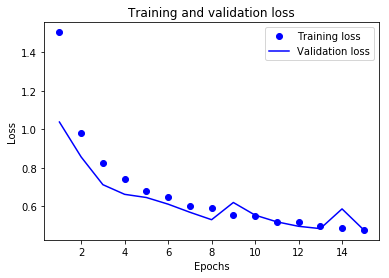

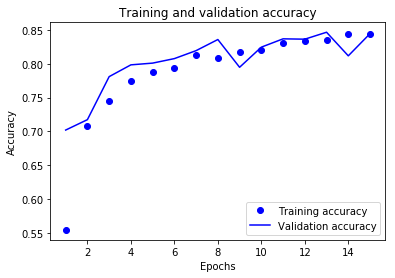

In [60]:
num_epochs=range(1,len(loss)+1)

plt.plot(num_epochs, loss, 'bo', label='Training loss')
plt.plot(num_epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()

plt.plot(num_epochs, acc, 'bo', label='Training accuracy')
plt.plot(num_epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**Heat Map**

In [61]:
train_pred = model.predict(X_train)
valid_pred = model.predict(X_valid)

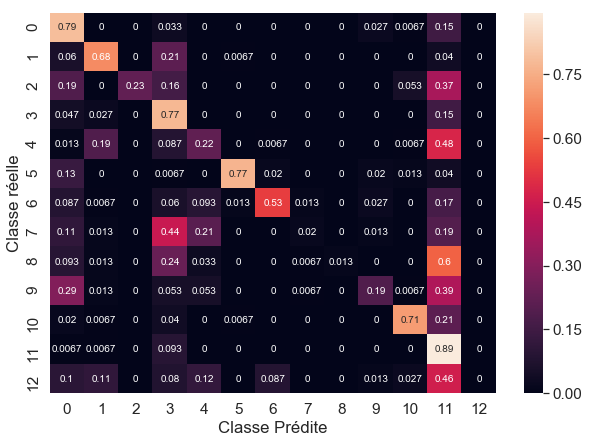

In [62]:
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix

array = confusion_matrix(D.data['Y_valid'], valid_pred.argmax(axis=1))
array = array.astype('float') / array.sum(axis=1)[:, np.newaxis]

df_cm = pd.DataFrame(array, range(13),range(13))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 10})# font size
plt.xlabel('Classe Prédite')
plt.ylabel('Classe réelle')
plt.show()

**Final Score**

In [63]:
batch_size=32
test_generator=test_datagen.flow(X_test, Y_test, batch_size=batch_size)
test_loss, test_acc = model.evaluate_generator(test_generator, steps=len(X_test)/batch_size)

In [64]:
print('Final Loss:', test_loss)
print('Final acc:', 100*test_acc)

Final Loss: 0.48969125983042594
Final acc: 84.61538457870483
